In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import time

import psydac.core.interface as inter

#import utilitis_FEEC.derivatives as der
#import utilitis_FEEC.projectors as proj
#import utilitis_FEEC.evaluation as eva
#import utilitis_FEEC.integrate as integr
import utilitis_FEEC.Bspline as bspline
import utilitis_FEEC.bsplines as bsp

# Poisson with mixed boundary conditions

In [43]:
Lx = 1.
Nel_x = 2
dx = Lx/Nel_x
el_b_x = np.linspace(0, Lx, Nel_x + 1)

px = 3

Nbase_x = Nel_x + px

Tx = inter.make_open_knots(px, Nbase_x)
tx = inter.make_open_knots(px - 1, Nbase_x - 1)

Bx = bspline.Bspline(Tx, px)
Dx = bspline.Bspline(tx, px - 1)

greville_x = inter.compute_greville(px, Nbase_x, Tx)

In [31]:
# model

x = sym.symbols('x')
u = x*sym.sin(2*sym.pi*x) + x*sym.cos(2*sym.pi*x) + 0.5

sigma = sym.diff(u, x)
f = -sym.diff(u, x, x)

u = sym.lambdify(x, u)
sigma = sym.lambdify(x, sigma)
f = sym.lambdify(x, f)

a = sigma(0)
b = u(Lx)

In [32]:
# assembly of lhs

M0 = integr.mass_matrix_V0_1d(px, Nbase_x, Tx, None)[1:,1:]
M1 = integr.mass_matrix_V1_1d(px, Nbase_x, Tx, None)
G = der.GRAD_1d(px, Nbase_x, None)[:,1:]

K = np.block([[M0, np.dot(G.T, M1)], [np.dot(M1, G), np.zeros((Nbase_x - 1, Nbase_x - 1))]])

In [33]:
# assembly of rhs_1

fbar = -integr.L2_prod_V1_1d(f, px, Nbase_x, Tx)

pts_loc, wts_loc = np.polynomial.legendre.leggauss(px + 1)
pts, wts = inter.construct_quadrature_grid(Nel_x, px + 1, pts_loc, wts_loc, el_b_x)

rhs_1 = np.zeros(Nbase_x - 1)

for i in range(1, Nbase_x):
    integrand = lambda x : Bx(x, i)*Bx(x, 0)
    
    rhs_1[i - 1] = -a*integr.integrate_1d(pts, wts, integrand).sum()
    
rhs_1[-1] = b

In [34]:
# assembly of rhs_2

fbar = integr.L2_prod_V1_1d(f, px, Nbase_x, Tx)

rhs_2 = np.zeros(Nbase_x - 1)

for i in range(0, Nbase_x - 1):
    integrand = lambda x : Dx(x, i)*Dx(x, 0)*px/(tx[px] - tx[0])*px/(tx[i + px] - tx[i])
    
    rhs_2[i] = a*integr.integrate_1d(pts, wts, integrand).sum()
    
rhs_2 = -fbar + rhs_2

rhs = np.append(rhs_1, rhs_2)

In [35]:
res = np.linalg.solve(K, rhs)

In [36]:
uvec = res[Nbase_x - 1:]
sigmavec = res[:Nbase_x - 1]

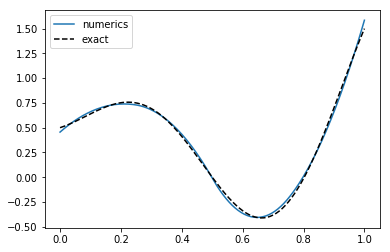

In [37]:
xplot = np.linspace(0, Lx, 201)

plt.plot(xplot, eva.evaluate_field_V1_1d(uvec, xplot, px, Nbase_x, Tx, bc), label = 'numerics')
plt.plot(xplot, u(xplot), 'k--', label = 'exact')

#plt.plot(xplot, eva.evaluate_field_V0_1d(np.append(sigmavec, b), xplot, px, Nbase_x, Tx, bc, full=True), label = 'numerics')
#plt.plot(xplot, sigma(xplot), 'k--', label = 'exact')
plt.legend()

# 1. Dirichlet boundary conditions

In [2]:
bc = False

Lx = 1.
Nel_x = 5
dx = Lx/Nel_x
el_b_x = np.linspace(0, Lx, Nel_x + 1)

px = 3

Nbase_x = Nel_x + px

Tx = inter.make_open_knots(px, Nbase_x)
tx = inter.make_open_knots(px - 1, Nbase_x - 1)

Bx = bspline.Bspline(Tx, px)
Dx = bspline.Bspline(tx, px - 1)

greville_x = inter.compute_greville(px, Nbase_x, Tx)

## 1. 1 Basis of $V_0$ with first derivative

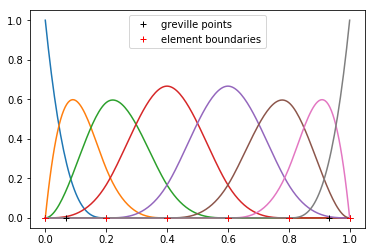

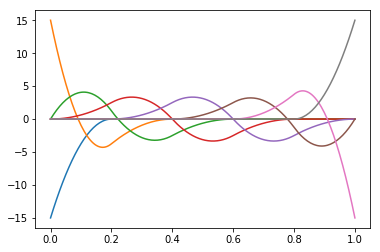

In [3]:
xplot = np.linspace(0, Lx, 200)

for j in range(Nbase_x):
    plt.plot(xplot, Bx(xplot, j))
    
plt.plot(greville_x, np.zeros(len(greville_x)), 'k+', label='greville points')
plt.plot(el_b_x, np.zeros(len(el_b_x)), 'r+', label='element boundaries')

plt.legend()

plt.figure()
for j in range(Nbase_x):
    plt.plot(xplot, Bx(xplot, j, 1))

In [85]:
greville_x

array([0. , 0.1, 0.3, 0.5, 0.7, 0.9, 1. ])

In [86]:
grid = np.union1d(greville_x, el_b_x)
n_greville = len(greville_x)

In [87]:
grid

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [88]:
ne = 2*Nel_x + px - 2

In [89]:
boundaries = int(px/2)

ies = np.floor_divide(np.arange(ne - px), 2) + boundaries

In [90]:
ne

10

In [91]:
ies = np.array(list(np.arange(boundaries)) + list(ies) + list(np.arange(boundaries) + ies[-1] + 1))

In [92]:
ies

array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5])

In [93]:
pts_loc, wts_loc = np.polynomial.legendre.leggauss(px)
pts, wts = bsp.quadrature_grid(grid, pts_loc, wts_loc)
basis = bsp.basis_ders_on_quad_grid(Tx, px, pts, 0, normalize=False)

In [94]:
D = np.zeros((n_greville - 1, px + 2))

In [95]:
il_add = np.array([0] * boundaries + [0, 1] * int((ne - px)/2) + [1] * boundaries)

In [96]:
il_add

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1])

In [98]:
D

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [81]:
for iee in range(ne):
    for il in range(px + 1):
        for k in range(px):
            D[ies[iee], il + il_add[iee]] += wts[iee, k] * basis[iee, il, 0, k]

In [82]:
D

array([[1.90673828e-02, 1.05743408e-02, 1.53435601e-03, 7.29031033e-05,
        1.01725260e-06, 0.00000000e+00],
       [5.90820312e-03, 2.99377441e-02, 2.19489204e-02, 4.45895725e-03,
        2.46175130e-04, 0.00000000e+00],
       [2.44140625e-05, 9.39025879e-03, 4.12628174e-02, 3.55397542e-02,
        7.50020345e-03, 3.25520833e-05],
       [9.76562500e-05, 1.02105035e-02, 5.21918403e-02, 5.47526042e-02,
        7.71484375e-03, 3.25520833e-05],
       [4.34027778e-05, 7.70399306e-03, 5.47526042e-02, 5.47526042e-02,
        7.71484375e-03, 3.25520833e-05],
       [3.25520833e-05, 7.71484375e-03, 5.47526042e-02, 5.47526042e-02,
        7.71484375e-03, 3.25520833e-05],
       [3.25520833e-05, 7.71484375e-03, 5.47526042e-02, 5.47526042e-02,
        7.70399306e-03, 4.34027778e-05],
       [3.25520833e-05, 7.71484375e-03, 5.47526042e-02, 5.21918403e-02,
        1.02105035e-02, 9.76562500e-05],
       [3.25520833e-05, 7.50020345e-03, 3.55397542e-02, 4.12628174e-02,
        9.39025879e-03, 

## 1. 2 Basis of $V_1$ and reconstruction of derivative of $V_0$

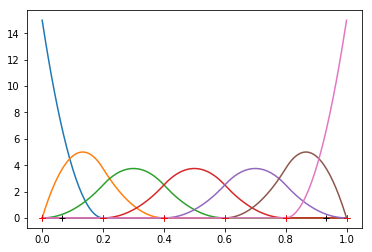

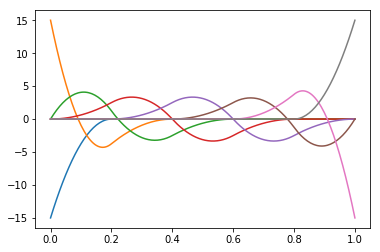

In [4]:
xplot = np.linspace(0, Lx, 200)

for j in range(Nbase_x - 1):
    plt.plot(xplot, px*Dx(xplot, j)/(tx[j + px] - tx[j]))
    
    
plt.plot(greville_x, np.zeros(len(greville_x)), 'k+', label='greville points')
plt.plot(el_b_x, np.zeros(len(el_b_x)), 'r+', label='element boundaries')

 
plt.figure()
for j in range(Nbase_x):
    
    if j == 0:
        plt.plot(xplot, -px*Dx(xplot, j)/(tx[j + px] - tx[j]))
        
    elif j == Nbase_x - 1:
        plt.plot(xplot, px*Dx(xplot, j - 1)/(tx[j + px - 1] - tx[j - 1]))
        
    else:
        plt.plot(xplot, px*Dx(xplot, j - 1)/(tx[j + px - 1] - tx[j - 1]) - px*Dx(xplot, j)/(tx[j + px] - tx[j]))

In [23]:
pts_x_loc, wts_x_loc = np.polynomial.legendre.leggauss(px)

pts_x, wts_x = inter.construct_quadrature_grid(Nel_x, px, pts_x_loc, wts_x_loc, el_b_x)

In [28]:
px*Dx(pts_x[:, 0], 1)/(tx[1 + px] - tx[1])

array([1.54763125, 4.6875    , 4.45236875])

In [30]:
Dx(pts_x[:, 0], 1)

array([0.20635083, 0.625     , 0.59364917])

## 1. 3 Test projectors $\Pi_0$ and $\Pi_1$

In [47]:
# test projector PI_0
Psi_0 = lambda x : x*np.sin(2*np.pi*x)

vec_0 = proj.PI_0_1d(Psi_0, px, Nbase_x, Tx, bc)

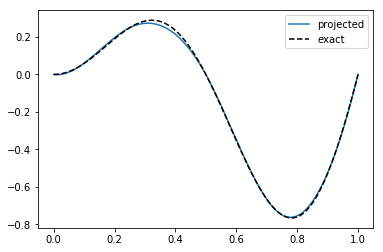

In [48]:
plt.plot(xplot, eva.evaluate_field_V0_1d(vec_0, xplot, px, Nbase_x, Tx, bc), label='projected')
plt.plot(xplot, Psi_0(xplot), 'k--', label='exact')
plt.legend()

In [49]:
# test projector PI_1
Psi_1 = lambda x : x*np.sin(2*np.pi*x)

vec_1 = proj.PI_1_1d(Psi_1, px, Nbase_x, Tx, bc)

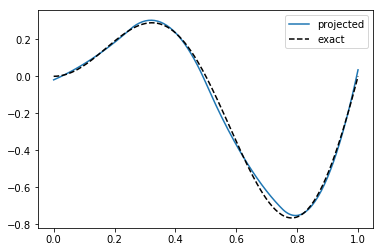

In [50]:
plt.plot(xplot, eva.evaluate_field_V1_1d(vec_1, xplot, px, Nbase_x, Tx, bc), label = 'projected')
plt.plot(xplot, Psi_1(xplot), 'k--', label = 'exact')
plt.legend()

## 1. 4 Test mass matrices with $L^2$-projection

In [12]:
# test mass matrix M0
Psi_0 = lambda x : x*np.sin(2*np.pi*x)
#Psi_0 = lambda x : x*(1 - x)

M0  = integr.mass_matrix_V0_1d(px, Nbase_x, Tx, bc)
rhs = integr.L2_prod_V0_1d(Psi_0, px, Nbase_x, Tx)[1:-1]

res = np.linalg.solve(M0, rhs)

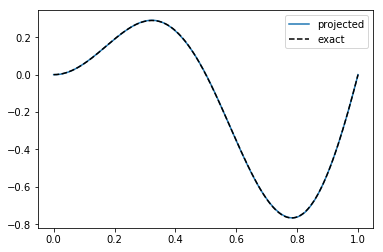

In [13]:
plt.plot(xplot, eva.evaluate_field_V0_1d(res, xplot, px, Nbase_x, Tx, bc), label = 'projected')
plt.plot(xplot, Psi_0(xplot), 'k--', label = 'exact')
plt.legend()

L2-error = 0.002986378840700379 , degree = 1 , Nel = 16
L2-error = 0.0007172626180950913 , degree = 1 , Nel = 32
L2-error = 0.000176637039292821 , degree = 1 , Nel = 64
L2-error = 4.388619216381341e-05 , degree = 1 , Nel = 128
L2-error = 1.0941285062941008e-05 , degree = 1 , Nel = 256
L2-error = 0.00018494466687572335 , degree = 2 , Nel = 16
L2-error = 2.207445599066058e-05 , degree = 2 , Nel = 32
L2-error = 2.7262758458476525e-06 , degree = 2 , Nel = 64
L2-error = 3.3974586838945257e-07 , degree = 2 , Nel = 128
L2-error = 4.243567807726651e-08 , degree = 2 , Nel = 256
L2-error = 1.4638157080651462e-05 , degree = 3 , Nel = 16
L2-error = 8.75666522623888e-07 , degree = 3 , Nel = 32
L2-error = 5.425928154805922e-08 , degree = 3 , Nel = 64
L2-error = 3.388957031190511e-09 , degree = 3 , Nel = 128
L2-error = 2.1193849644527919e-10 , degree = 3 , Nel = 256


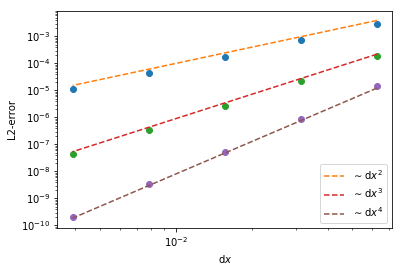

In [14]:
# check convergence
from scipy.integrate import fixed_quad

cases_p = 3
cases_e = 5

L2_error = np.zeros((cases_p, cases_e))
dxs = np.zeros((cases_p, cases_e))

for p in range(1, cases_p + 1):
    for i in range(3, 3 + cases_e):
        Nel = 2*2**i
        el_b = np.linspace(0, Lx, Nel + 1)
        dxs[p - 1, i - 3] = Lx/Nel
        
        Nbase = Nel + p
        T = inter.make_open_knots(p, Nbase) 
        
        m0 = integr.mass_matrix_V0_1d(p, Nbase, T, bc)
        rh = integr.L2_prod_V0_1d(Psi_0, p, Nbase, T)[1:-1]
        re = np.linalg.solve(m0, rh)
        
        # L2-error
        diff = lambda x : (Psi_0(x) - eva.evaluate_field_V0_1d(re, x, p, Nbase, T, bc))**2
        
        for k in range(Nel):
            L2_error[p - 1, i - 3] += fixed_quad(diff, el_b[k], el_b[k + 1])[0]
            
        L2_error[p - 1, i - 3] = np.sqrt(L2_error[p - 1, i - 3]) 
        print('L2-error =', L2_error[p - 1, i - 3], ', degree =' , p, ', Nel =', Nel)

        
abzisse = np.array([1, 0.9, 0.8]) 
labels = ['$\sim \mathrm{d}x^2$', '$\sim \mathrm{d}x^3$', '$\sim  \mathrm{d}x^4$']
        
for p in range(cases_p):
    plt.loglog(dxs[p], L2_error[p], 'o')
    plt.loglog(dxs[p], abzisse[p]*dxs[p]**(p + 2), '--', label = labels[p])

plt.xlabel('$\mathrm{d}x$')
plt.ylabel('L2-error')
plt.legend()

In [29]:
# test mass matrix M1
Psi_0 = lambda x : x*np.sin(2*np.pi*x)

M1  = integr.mass_matrix_V1_1d(px, Nbase_x, Tx, bc)
rhs = integr.L2_prod_V1_1d(Psi_0, px, Nbase_x, Tx)

res = np.linalg.solve(M1, rhs)

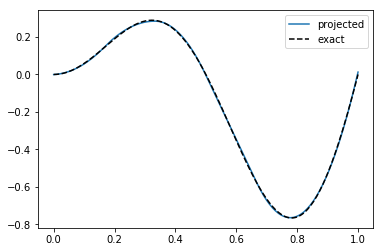

In [30]:
plt.plot(xplot, eva.evaluate_field_V1_1d(res, xplot, px, Nbase_x, Tx, bc), label = 'projected')
plt.plot(xplot, Psi_0(xplot), 'k--', label = 'exact')
plt.legend()

L2-error = 0.0028461729637857835 , degree = 2 , Nel = 16
L2-error = 0.0007018581064195039 , degree = 2 , Nel = 32
L2-error = 0.00017483334878673671 , degree = 2 , Nel = 64
L2-error = 4.3668035996803726e-05 , degree = 2 , Nel = 128
L2-error = 1.0914462676301578e-05 , degree = 2 , Nel = 256
L2-error = 0.00017613384331642968 , degree = 3 , Nel = 16
L2-error = 2.1532900348307238e-05 , degree = 3 , Nel = 32
L2-error = 2.692763485698761e-06 , degree = 3 , Nel = 64
L2-error = 3.3766213192617555e-07 , degree = 3 , Nel = 128
L2-error = 4.2305782401442e-08 , degree = 3 , Nel = 256
L2-error = 1.4630047609781715e-05 , degree = 4 , Nel = 16
L2-error = 8.755263831657717e-07 , degree = 4 , Nel = 32
L2-error = 5.425451330801368e-08 , degree = 4 , Nel = 64
L2-error = 3.3887798529074517e-09 , degree = 4 , Nel = 128
L2-error = 2.1193232411835854e-10 , degree = 4 , Nel = 256


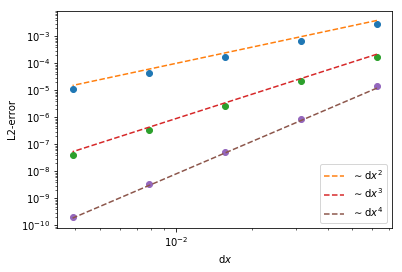

In [14]:
# check convergence
from scipy.integrate import fixed_quad

cases_p = 3
cases_e = 5

L2_error = np.zeros((cases_p, cases_e))
dxs = np.zeros((cases_p, cases_e))

for p in range(2, cases_p + 2):
    for i in range(3, 3 + cases_e):
        Nel = 2*2**i
        el_b = np.linspace(0, Lx, Nel + 1)
        dxs[p - 2, i - 3] = Lx/Nel
        
        Nbase = Nel + p
        T = inter.make_open_knots(p, Nbase) 
        
        m1 = integr.mass_matrix_V1_1d(p, Nbase, T, bc)
        rh = integr.L2_prod_V1_1d(Psi_0, p, Nbase, T)
        re = np.linalg.solve(m1, rh)
        
        # L2-error
        diff = lambda x : (Psi_0(x) - eva.evaluate_field_V1_1d(re, x, p, Nbase, T, bc))**2
        
        for k in range(Nel):
            L2_error[p - 2, i - 3] += fixed_quad(diff, el_b[k], el_b[k + 1])[0]
            
        L2_error[p - 2, i - 3] = np.sqrt(L2_error[p - 2, i - 3]) 
        print('L2-error =', L2_error[p - 2, i - 3], ', degree =' , p, ', Nel =', Nel)

        
abzisse = np.array([1, 0.9, 0.8])
labels = ['$\sim \mathrm{d}x^2$', '$\sim \mathrm{d}x^3$', '$\sim  \mathrm{d}x^4$']
        
for p in range(cases_p):
    plt.loglog(dxs[p], L2_error[p], 'o')
    plt.loglog(dxs[p], abzisse[p]*dxs[p]**(p + 2),'--', label = labels[p])

plt.xlabel('$\mathrm{d}x$')
plt.ylabel('L2-error')
plt.legend()

## 1. 5 Poisson equation

In [51]:
x = sym.symbols('x')
u = x*sym.sin(2*sym.pi*x)

f = -sym.diff(u, x, x)
f = sym.lambdify(x, f)
u = sym.lambdify(x, u)

In [52]:
G  = der.GRAD_1d(px, Nbase_x, bc)
M0 = integr.mass_matrix_V0_1d(px, Nbase_x, Tx, bc)
M1 = integr.mass_matrix_V1_1d(px, Nbase_x, Tx, bc)
rhs = integr.L2_prod_V0_1d(f, px, Nbase_x, Tx)[1:-1]

In [53]:
temp0 = np.zeros((np.dot(np.transpose(G), M1).shape[0], np.dot(M1, G).shape[1]))
Block = np.block([[M1, np.dot(M1, G)], [-np.dot(np.transpose(G), M1), temp0]])

RHS = np.append(np.zeros(M1.shape[0]), rhs)

res = np.linalg.solve(Block, RHS)

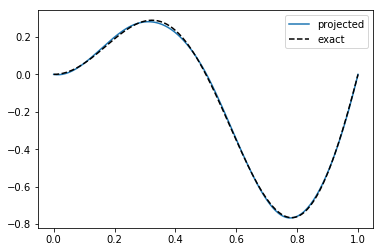

In [54]:
plt.plot(xplot, eva.evaluate_field_V0_1d(res[M1.shape[0]:], xplot, px, Nbase_x, Tx, bc), label = 'projected')
plt.plot(xplot, u(xplot), 'k--', label = 'exact')
plt.legend()

L2-error = 0.00018631911925224727 , degree = 2 , Nel = 16
L2-error = 2.2116020018377174e-05 , degree = 2 , Nel = 32
L2-error = 2.7275574326896916e-06 , degree = 2 , Nel = 64
L2-error = 3.397856899917951e-07 , degree = 2 , Nel = 128
L2-error = 4.243691906342752e-08 , degree = 2 , Nel = 256
L2-error = 1.4654462826935455e-05 , degree = 3 , Nel = 16
L2-error = 8.759023145835497e-07 , degree = 3 , Nel = 32
L2-error = 5.426368595872292e-08 , degree = 3 , Nel = 64
L2-error = 3.3890617470693624e-09 , degree = 3 , Nel = 128
L2-error = 2.1194137572941908e-10 , degree = 3 , Nel = 256
L2-error = 9.855186119392475e-07 , degree = 4 , Nel = 16
L2-error = 2.826029656272733e-08 , degree = 4 , Nel = 32
L2-error = 8.635337347733904e-10 , degree = 4 , Nel = 64
L2-error = 2.6846331928773644e-11 , degree = 4 , Nel = 128
L2-error = 8.392278486569679e-13 , degree = 4 , Nel = 256


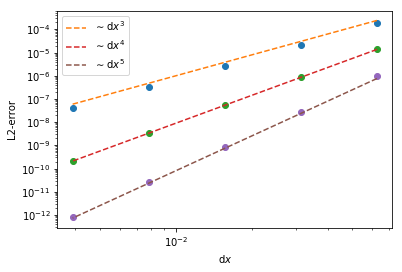

In [42]:
# check convergence
from scipy.integrate import fixed_quad

cases_p = 3
cases_e = 5

L2_error = np.zeros((cases_p, cases_e))
dxs = np.zeros((cases_p, cases_e))

for p in range(2, cases_p + 2):
    for i in range(3, 3 + cases_e):
        Nel = 2*2**i
        el_b = np.linspace(0, Lx, Nel + 1)
        dxs[p - 2, i - 3] = Lx/Nel
        
        Nbase = Nel + p
        T = inter.make_open_knots(p, Nbase) 
        
        G  = der.GRAD_1d(p, Nbase, bc)
        m0 = integr.mass_matrix_V0_1d(p, Nbase, T, bc)
        m1 = integr.mass_matrix_V1_1d(p, Nbase, T, bc)
        rh = integr.L2_prod_V0_1d(f, p, Nbase, T)[1:-1]
        
        temp0 = np.zeros((np.dot(np.transpose(G), m1).shape[0], np.dot(m1, G).shape[1]))
        Block = np.block([[m1, np.dot(m1, G)], [-np.dot(np.transpose(G), m1), temp0]])

        RHS = np.append(np.zeros(m1.shape[0]), rh)

        re = np.linalg.solve(Block, RHS)
        
        # L2-error
        diff = lambda x : (u(x) - eva.evaluate_field_V0_1d(re[m1.shape[0]:], x, p, Nbase, T, bc))**2
        
        for k in range(Nel):
            L2_error[p - 2, i - 3] += fixed_quad(diff, el_b[k], el_b[k + 1])[0]
            
        L2_error[p - 2, i - 3] = np.sqrt(L2_error[p - 2, i - 3]) 
        print('L2-error =', L2_error[p - 2, i - 3], ', degree =' , p, ', Nel =', Nel)

        
abzisse = np.array([1, 0.9, 0.8])
labels = ['$\sim \mathrm{d}x^3$', '$\sim \mathrm{d}x^4$', '$\sim  \mathrm{d}x^5$']
        
for p in range(cases_p):
    plt.loglog(dxs[p], L2_error[p], 'o')
    plt.loglog(dxs[p], abzisse[p]*dxs[p]**(p + 3),'--', label = labels[p])

plt.xlabel('$\mathrm{d}x$')
plt.ylabel('L2-error')
plt.legend()

# 2. Periodic boundary conditions

In [2]:
import utilitis_FEEC.bsplines as bsp

bc = True

Lx = 1.0
Nel_x = 5
dx = Lx/Nel_x
el_b_x = np.linspace(0, Lx, Nel_x + 1)

px = 3

Nbase_x = Nel_x + px

Tx = inter.make_periodic_knots(px, Nbase_x)
tx = inter.make_periodic_knots(px - 1, Nbase_x - 1)

Bx = bspline.Bspline(Tx, px)
Dx = bspline.Bspline(tx, px - 1)

greville_x = (inter.compute_greville(px, Nbase_x, Tx))%Lx

## 1. 1 Basis of $V_0$ with first derivative

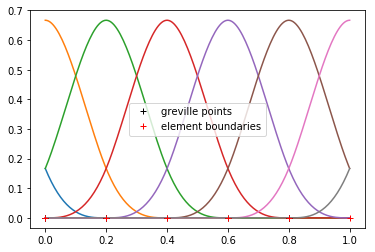

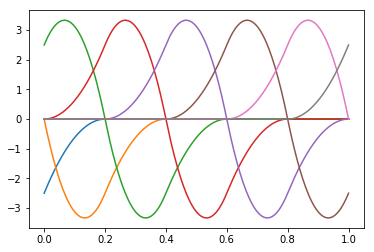

In [3]:
xplot = np.linspace(0, Lx, 200)

for j in range(Nbase_x):
    plt.plot(xplot, Bx(xplot, j))
    
plt.plot(greville_x, np.zeros(len(greville_x)), 'k+', label='greville points')
plt.plot(el_b_x, np.zeros(len(el_b_x)), 'r+', label='element boundaries')
plt.legend()

plt.figure()
for j in range(Nbase_x):
    plt.plot(xplot, Bx(xplot, j, 1))

In [75]:
grev = bsp.greville(Tx, px, bc)

In [76]:
grid = np.append(grev, grev + dx/2)

In [77]:
grid = np.append(grid, grid[-1] + dx/2)

In [78]:
grid.sort()

In [79]:
grid

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])

In [80]:
pts_loc, wts_loc = np.polynomial.legendre.leggauss(px)
pts, wts = bsp.quadrature_grid(grid, pts_loc, wts_loc)

In [83]:
basis = bsp.basis_ders_on_quad_grid(Tx, px, pts%1., 0, normalize=False)

In [107]:
D = np.zeros((Nel_x, px + 2))

In [108]:
for iee in range(2*Nel_x):
    
    ie = int(np.floor(iee/2))
    print(ie)
    
    for il in range(px + 1):
        #print(il + iee%2)
        
        for k in range(px):
            D[ie, il + iee%2] += wts[iee, k] * basis[iee, il, 0, k]

0
0
1
1
2
2
3
3
4
4


In [109]:
D

array([[0.00416667, 0.09583333, 0.09583333, 0.00416667],
       [0.00416667, 0.09583333, 0.09583333, 0.00416667],
       [0.00416667, 0.09583333, 0.09583333, 0.00416667],
       [0.00416667, 0.09583333, 0.09583333, 0.00416667],
       [0.00416667, 0.09583333, 0.09583333, 0.00416667]])

## 1. 2 Basis of $V_1$ and reconstruction of derivative of $V_0$

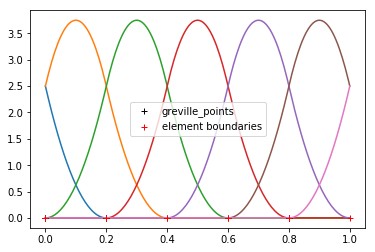

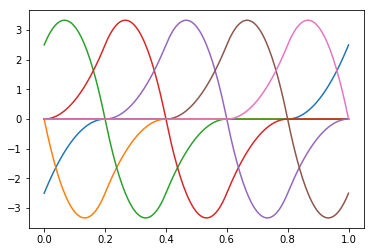

In [4]:
xplot = np.linspace(0, Lx, 200)


for j in range(Nbase_x - 1):
    plt.plot(xplot, px*Dx(xplot, j)/(tx[j + px] - tx[j]))

plt.plot(greville_x, np.zeros(len(greville_x)), 'k+', label='greville_points')
plt.plot(el_b_x, np.zeros(len(el_b_x)), 'r+', label='element boundaries')
plt.legend()
    
    
plt.figure()
for j in range(Nbase_x - 1):
    plt.plot(xplot, (px*Dx(xplot, j - 1)/(tx[j + px] - tx[j]) - px*Dx(xplot, j)/(tx[j + px] - tx[j])))

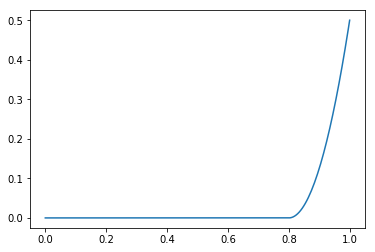

In [15]:
plt.plot(xplot, Dx(xplot, -1))

## 1. 3 Test projectors $\Pi_0$ and $\Pi_1$

In [57]:
# test projector PI_0
shift = 0.5
Psi_0 = lambda x : 1/(0.5*np.cos(2*np.pi*x) + 1)*np.sin(2*np.pi*x) + shift

vec_0 = proj.PI_0_1d(Psi_0, px, Nbase_x, Tx, bc)

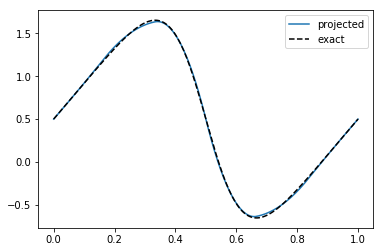

In [58]:
plt.plot(xplot, eva.evaluate_field_V0_1d(vec_0, xplot, px, Nbase_x, Tx, bc), label='projected')
plt.plot(xplot, Psi_0(xplot), 'k--', label='exact')
plt.legend()

In [59]:
# test projector PI_1
shift = 0.5
Psi_1 = lambda x : 1/(0.5*np.cos(2*np.pi*x) + 1)*np.sin(2*np.pi*x) + shift

vec_1 = proj.PI_1_1d(Psi_0, px, Nbase_x, Tx, bc)

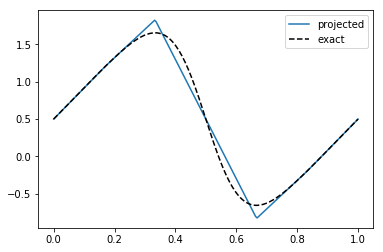

In [60]:
plt.plot(xplot, eva.evaluate_field_V1_1d(vec_1, xplot, px, Nbase_x, Tx, bc), label = 'projected')
plt.plot(xplot, Psi_1(xplot), 'k--', label = 'exact')
plt.legend()

## 1. 4 Test mass matrices with $L^2$-projection

In [61]:
# test mass matrix M0
shift = 0.5
Psi_0 = lambda x : 1/(0.5*np.cos(2*np.pi*x) + 1)*np.sin(2*np.pi*x) + shift

M0  = integr.mass_matrix_V0_1d(px, Nbase_x, Tx, bc)

rhs = integr.L2_prod_V0_1d(Psi_0, px, Nbase_x, Tx)
rhs[:px] += rhs[-px:]
rhs = rhs[:rhs.size - px]

res = np.linalg.solve(M0, rhs)

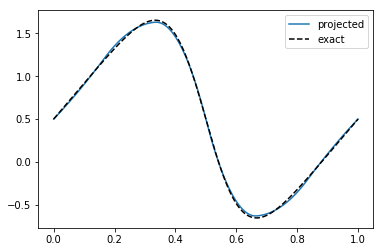

In [62]:
plt.plot(xplot, eva.evaluate_field_V0_1d(res, xplot, px, Nbase_x, Tx, bc), label = 'projected')
plt.plot(xplot, Psi_0(xplot), 'k--', label = 'exact')
plt.legend()

L2-error = 0.011454178099905036 , degree = 1 , Nel = 16
L2-error = 0.0027194023986771075 , degree = 1 , Nel = 32
L2-error = 0.0006713341395038949 , degree = 1 , Nel = 64
L2-error = 0.00016730950455095777 , degree = 1 , Nel = 128
L2-error = 4.179475295397927e-05 , degree = 1 , Nel = 256
L2-error = 0.0012373189005378806 , degree = 2 , Nel = 16
L2-error = 0.0001210546412215064 , degree = 2 , Nel = 32
L2-error = 1.4213938470382461e-05 , degree = 2 , Nel = 64
L2-error = 1.749029115029747e-06 , degree = 2 , Nel = 128
L2-error = 2.177697023311909e-07 , degree = 2 , Nel = 256
L2-error = 0.0003655251173620781 , degree = 3 , Nel = 16
L2-error = 1.2209265541835593e-05 , degree = 3 , Nel = 32
L2-error = 6.495300973711586e-07 , degree = 3 , Nel = 64
L2-error = 3.892885767298474e-08 , degree = 3 , Nel = 128
L2-error = 2.407368363607277e-09 , degree = 3 , Nel = 256


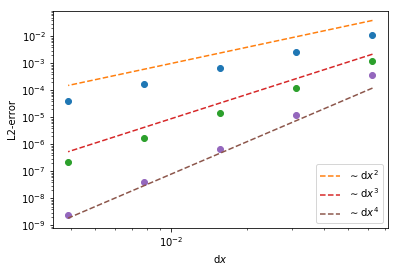

In [63]:
# check convergence
from scipy.integrate import fixed_quad

cases_p = 3
cases_e = 5

L2_error = np.zeros((cases_p, cases_e))
dxs = np.zeros((cases_p, cases_e))

for p in range(1, cases_p + 1):
    for i in range(3, 3 + cases_e):
        Nel = 2*2**i
        el_b = np.linspace(0, Lx, Nel + 1)
        dxs[p - 1, i - 3] = Lx/Nel
        
        Nbase = Nel + p
        T = inter.make_periodic_knots(p, Nbase) 
        
        m0 = integr.mass_matrix_V0_1d(p, Nbase, T, bc)
        
        rh = integr.L2_prod_V0_1d(Psi_0, p, Nbase , T)
        rh[:p] += rh[-p:]
        rh = rh[:rh.size - p]
        
        re = np.linalg.solve(m0, rh)
        
        # L2-error
        diff = lambda x : (Psi_0(x) - eva.evaluate_field_V0_1d(re, x, p, Nbase, T, bc))**2
        
        for k in range(Nel):
            L2_error[p - 1, i - 3] += fixed_quad(diff, el_b[k], el_b[k + 1])[0]
            
        L2_error[p - 1, i - 3] = np.sqrt(L2_error[p - 1, i - 3]) 
        print('L2-error =', L2_error[p - 1, i - 3], ', degree =' , p, ', Nel =', Nel)

        
abzisse = np.array([10, 9, 8]) 
labels = ['$\sim \mathrm{d}x^2$', '$\sim \mathrm{d}x^3$', '$\sim  \mathrm{d}x^4$']
        
for p in range(cases_p):
    plt.loglog(dxs[p], L2_error[p], 'o')
    plt.loglog(dxs[p], abzisse[p]*dxs[p]**(p + 2), '--', label = labels[p])

plt.xlabel('$\mathrm{d}x$')
plt.ylabel('L2-error')
plt.legend()

In [64]:
# test mass matrix M1
shift = 0.5
Psi_1 = lambda x : 1/(0.5*np.cos(2*np.pi*x) + 1)*np.sin(2*np.pi*x) + shift

M1  = integr.mass_matrix_V1_1d(px, Nbase_x, Tx, bc)

rhs = integr.L2_prod_V1_1d(Psi_1, px, Nbase_x, Tx)
rhs[:(px - 1)] += rhs[-(px - 1):]
rhs = rhs[:rhs.size - (px - 1)]

res = np.linalg.solve(M1, rhs)

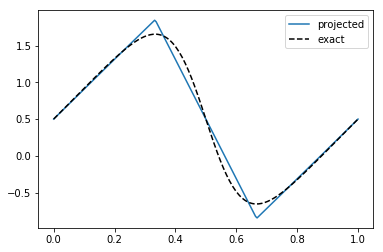

In [65]:
plt.plot(xplot, eva.evaluate_field_V1_1d(res, xplot, px, Nbase_x, Tx, bc), label = 'projected')
plt.plot(xplot, Psi_0(xplot), 'k--', label = 'exact')
plt.legend()

L2-error = 0.007723004060700014 , degree = 2 , Nel = 16
L2-error = 0.0018181174580059196 , degree = 2 , Nel = 32
L2-error = 0.0004478770437343503 , degree = 2 , Nel = 64
L2-error = 0.00011155968348775013 , degree = 2 , Nel = 128
L2-error = 2.7864418787377277e-05 , degree = 2 , Nel = 256
L2-error = 0.0012278357619960416 , degree = 3 , Nel = 16
L2-error = 0.00012079500927516316 , degree = 3 , Nel = 32
L2-error = 1.4205988822763029e-05 , degree = 3 , Nel = 64
L2-error = 1.7487818056842864e-06 , degree = 3 , Nel = 128
L2-error = 2.177619823304211e-07 , degree = 3 , Nel = 256
L2-error = 0.0003655115938960261 , degree = 4 , Nel = 16
L2-error = 1.2209209930670203e-05 , degree = 4 , Nel = 32
L2-error = 6.495298867774557e-07 , degree = 4 , Nel = 64
L2-error = 3.8928856850046735e-08 , degree = 4 , Nel = 128
L2-error = 2.4073683638526457e-09 , degree = 4 , Nel = 256


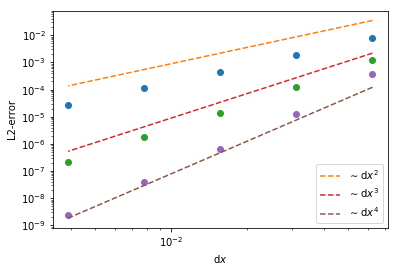

In [66]:
# check convergence
from scipy.integrate import fixed_quad

cases_p = 3
cases_e = 5

L2_error = np.zeros((cases_p, cases_e))
dxs = np.zeros((cases_p, cases_e))

for p in range(2, cases_p + 2):
    for i in range(3, 3 + cases_e):
        Nel = 2*2**i
        el_b = np.linspace(0, Lx, Nel + 1)
        dxs[p - 2, i - 3] = Lx/Nel
        
        Nbase = Nel + p
        T = inter.make_periodic_knots(p, Nbase) 
        
        m1 = integr.mass_matrix_V1_1d(p, Nbase, T, bc)
        
        rh = integr.L2_prod_V1_1d(Psi_0, p, Nbase, T)
        rh[:(p - 1)] += rh[-(p - 1):]
        rh = rh[:rh.size - (p - 1)]
        
        re = np.linalg.solve(m1, rh)
        
        # L2-error
        diff = lambda x : (Psi_0(x) - eva.evaluate_field_V1_1d(re, x, p, Nbase, T, bc))**2
        
        for k in range(Nel):
            L2_error[p - 2, i - 3] += fixed_quad(diff, el_b[k], el_b[k + 1])[0]
            
        L2_error[p - 2, i - 3] = np.sqrt(L2_error[p - 2, i - 3]) 
        print('L2-error =', L2_error[p - 2, i - 3], ', degree =' , p, ', Nel =', Nel)

        
abzisse = np.array([9, 9, 8])
labels = ['$\sim \mathrm{d}x^2$', '$\sim \mathrm{d}x^3$', '$\sim  \mathrm{d}x^4$']
        
for p in range(cases_p):
    plt.loglog(dxs[p], L2_error[p], 'o')
    plt.loglog(dxs[p], abzisse[p]*dxs[p]**(p + 2),'--', label = labels[p])

plt.xlabel('$\mathrm{d}x$')
plt.ylabel('L2-error')
plt.legend()

## 1. 5 Poisson equation

In [67]:
shift = 0.5
x = sym.symbols('x')
u = 1/(0.5*sym.cos(x*2*sym.pi) + 1)*sym.sin(x*2*sym.pi) + shift

f = -sym.diff(u, x, x)
f = sym.lambdify(x, f)
u = sym.lambdify(x, u)

In [68]:
G  = der.GRAD_1d(px, Nbase_x, bc)
M0 = integr.mass_matrix_V0_1d(px, Nbase_x, Tx, bc)
M1 = integr.mass_matrix_V1_1d(px, Nbase_x, Tx, bc)

rhs = integr.L2_prod_V0_1d(f, px, Nbase_x, Tx)
rhs[:px] += rhs[-px:]
rhs = rhs[:rhs.size - px]

In [69]:
mat = -np.dot(np.transpose(G), M1)
mat[-1] = 0.

temp0 = np.zeros((np.dot(np.transpose(G), M1).shape[0], np.dot(M1, G).shape[1]))

norm = integr.normalization_V0_1d(px, Nbase_x, Tx)
norm[:px] += norm[-px:]
norm = norm[:norm.size - px]

temp0[-1] = norm/Lx

Block = np.block([[M1, np.dot(M1, G)], [mat, temp0]])

RHS = np.append(np.zeros(M1.shape[0]), rhs)
RHS[-1] = shift

res = np.linalg.solve(Block, RHS)

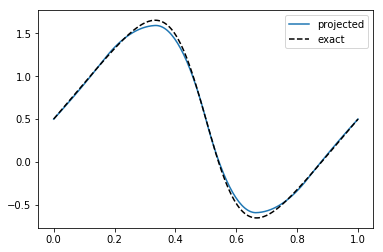

In [70]:
plt.plot(xplot, eva.evaluate_field_V0_1d(res[M1.shape[0]:], xplot, px, Nbase_x, Tx, bc), label = 'projected')
plt.plot(xplot, u(xplot), 'k--', label = 'exact')
plt.legend()

L2-error = 0.001322252858318393 , degree = 2 , Nel = 16
L2-error = 0.00012327471398753642 , degree = 2 , Nel = 32
L2-error = 1.4278663124321233e-05 , degree = 2 , Nel = 64
L2-error = 1.7510163841815138e-06 , degree = 2 , Nel = 128
L2-error = 2.178315304837135e-07 , degree = 2 , Nel = 256
L2-error = 0.00036962046098595446 , degree = 3 , Nel = 16
L2-error = 1.2215416325600732e-05 , degree = 3 , Nel = 32
L2-error = 6.495445050029684e-07 , degree = 3 , Nel = 64
L2-error = 3.892890707253668e-08 , degree = 3 , Nel = 128
L2-error = 2.4073685514342266e-09 , degree = 3 , Nel = 256
L2-error = 0.0001408186011782825 , degree = 4 , Nel = 16
L2-error = 1.7314106928641467e-06 , degree = 4 , Nel = 32
L2-error = 3.893817079956513e-08 , degree = 4 , Nel = 64
L2-error = 1.1105571079270578e-09 , degree = 4 , Nel = 128
L2-error = 3.3891689728220716e-11 , degree = 4 , Nel = 256


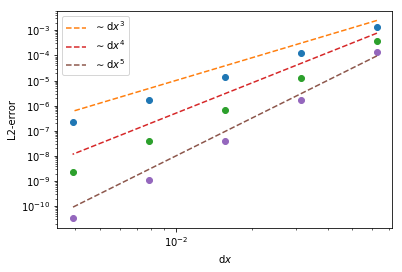

In [71]:
# check convergence
from scipy.integrate import fixed_quad

cases_p = 3
cases_e = 5

L2_error = np.zeros((cases_p, cases_e))
dxs = np.zeros((cases_p, cases_e))

for p in range(2, cases_p + 2):
    for i in range(3, 3 + cases_e):
        Nel = 2*2**i
        el_b = np.linspace(0, Lx, Nel + 1)
        dxs[p - 2, i - 3] = Lx/Nel
        
        Nbase = Nel + p
        T = inter.make_periodic_knots(p, Nbase) 
        
        G  = der.GRAD_1d(p, Nbase, bc)
        m0 = integr.mass_matrix_V0_1d(p, Nbase, T, bc)
        m1 = integr.mass_matrix_V1_1d(p, Nbase, T, bc)
        
        rh = integr.L2_prod_V0_1d(f, p, Nbase, T)
        rh[:p] += rh[-p:]
        rh = rh[:rh.size - p]
        
        mat = -np.dot(np.transpose(G), m1)
        mat[-1] = 0.
        
        temp0 = np.zeros((np.dot(np.transpose(G), m1).shape[0], np.dot(m1, G).shape[1]))
        
        norm = integr.normalization_V0_1d(p, Nbase, T)
        norm[:p] += norm[-p:]
        norm = norm[:norm.size - p]
        
        temp0[-1] = norm/Lx

        Block = np.block([[m1, np.dot(m1, G)], [mat, temp0]])
        
        RHS = np.append(np.zeros(m1.shape[0]), rh)
        RHS[-1] = shift

        re = np.linalg.solve(Block, RHS)
        
        # L2-error
        diff = lambda x : (u(x) - eva.evaluate_field_V0_1d(re[m1.shape[0]:], x, p, Nbase, T, bc))**2
        
        for k in range(Nel):
            L2_error[p - 2, i - 3] += fixed_quad(diff, el_b[k], el_b[k + 1])[0]
            
        L2_error[p - 2, i - 3] = np.sqrt(L2_error[p - 2, i - 3]) 
        print('L2-error =', L2_error[p - 2, i - 3], ', degree =' , p, ', Nel =', Nel)

        
abzisse = np.array([10, 50, 100])
labels = ['$\sim \mathrm{d}x^3$', '$\sim \mathrm{d}x^4$', '$\sim  \mathrm{d}x^5$']
        
for p in range(cases_p):
    plt.loglog(dxs[p], L2_error[p], 'o')
    plt.loglog(dxs[p], abzisse[p]*dxs[p]**(p + 3),'--', label = labels[p])

plt.xlabel('$\mathrm{d}x$')
plt.ylabel('L2-error')
plt.legend()